# Generate Dataset from all the simulation data

Output format: csv

## Sample:
```
WN1,WP1,VTH
1.0,1.5,0.6667504808394307
1.0,2.0,0.6749539226398081
1.0,2.5,0.6769565523806391
```

VTH - Flipping voltage of the modelled LIQAF

In [1]:
import pandas as pd
import numpy as np
import time 
import matplotlib.pyplot as plt
from __future__ import division 
df = pd.read_csv('sim_data.csv')
print(df)
print(df.keys())
simulation_points = 184
batches = int((df.shape[0]+1)/simulation_points)
print('Batches = ', batches)

                     yes       actual_WN1      actual_WP1 
0         1.00000000e+00   1.00000000e+00  1.50000000e+00 
1                v-sweep          v(Vout)              NaN
2         0.00000000e+00  1.79999995e+00               NaN
3         1.00000000e-02  1.79999995e+00               NaN
4         2.00000000e-02  1.79999995e+00               NaN
...                  ...              ...              ...
5514842   1.76000000e+00  3.57761700e-10               NaN
5514843   1.77000000e+00  3.66881688e-10               NaN
5514844   1.78000000e+00  3.76463129e-10               NaN
5514845   1.79000000e+00  3.86518670e-10               NaN
5514846   1.80000000e+00  3.97061791e-10               NaN

[5514847 rows x 3 columns]
Index([' yes', 'actual_WN1', 'actual_WP1 '], dtype='object')
Batches =  29972


In [2]:
def interpolated_intercept(x, y1, y2):
    """Find the intercept of two curves, given by the same x data"""

    def intercept(point1, point2, point3, point4):
        """find the intersection between two lines
        the first line is defined by the line between point1 and point2
        the first line is defined by the line between point3 and point4
        each point is an (x,y) tuple.

        So, for example, you can find the intersection between
        intercept((0,0), (1,1), (0,1), (1,0)) = (0.5, 0.5)

        Returns: the intercept, in (x,y) format
        """    

        def line(p1, p2):
            A = (p1[1] - p2[1])
            B = (p2[0] - p1[0])
            C = (p1[0]*p2[1] - p2[0]*p1[1])
            return A, B, -C

        def intersection(L1, L2):
            D  = L1[0] * L2[1] - L1[1] * L2[0]
            Dx = L1[2] * L2[1] - L1[1] * L2[2]
            Dy = L1[0] * L2[2] - L1[2] * L2[0]

            x = Dx / D
            y = Dy / D
            return x,y

        L1 = line([point1[0],point1[1]], [point2[0],point2[1]])
        L2 = line([point3[0],point3[1]], [point4[0],point4[1]])

        R = intersection(L1, L2)

        return R

    idx = np.argwhere(np.diff(np.sign(y1 - y2)) != 0)
    xc, yc = intercept((x[idx], y1[idx]),((x[idx+1], y1[idx+1])), ((x[idx], y2[idx])), ((x[idx+1], y2[idx+1])))
    return xc,yc


0.6470991904921811
(3.5, 4.0, 0.6470991904921811)


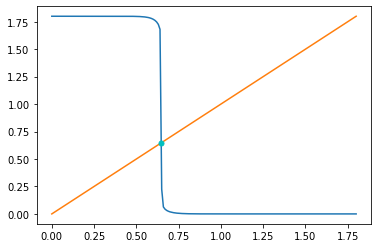

In [3]:
batch_number = 1000
batch_start = batch_number * simulation_points
sub_data = df[ batch_start : batch_start + simulation_points-1]
# print(sub_data)
WN1 = float(sub_data['actual_WN1'][batch_start])
WP1 = float(sub_data['actual_WP1 '][batch_start])

VIN = np.fromiter(map(float, sub_data[' yes'][2:]), dtype=np.float64)
VOUT = np.fromiter(map(float, sub_data['actual_WN1'][2:]), dtype=np.float64)

xc, yc = interpolated_intercept(VIN,VIN,VOUT)
VTH = xc[0][0]

plt.plot(VIN, VOUT, VIN, VIN)
plt.plot(xc, yc, 'co', ms=5, label='Nearest data-point, with linear interpolation')

print(VTH)

data = (WN1, WP1, VTH)
print(data)

In [4]:
out = pd.DataFrame(columns = ['WN1', 'WP1', 'VTH'])
for batch_number in range(0,batches):
    batch_start = batch_number * simulation_points
    sub_data = df[ batch_start : batch_start + simulation_points-1]
    # print(sub_data)
    WN1 = float(sub_data['actual_WN1'][batch_start])
    WP1 = float(sub_data['actual_WP1 '][batch_start])

    VIN = np.fromiter(map(float, sub_data[' yes'][2:]), dtype=np.float64)
    VOUT = np.fromiter(map(float, sub_data['actual_WN1'][2:]), dtype=np.float64)

    xc, yc = interpolated_intercept(VIN,VIN,VOUT)
    VTH = xc[0][0]

    out = out.append({'WN1':WN1, 'WP1':WP1, 'VTH':VTH}, ignore_index= True)
print(out)

        WN1   WP1       VTH
0       1.0   1.5  0.666750
1       1.0   2.0  0.674954
2       1.0   2.5  0.676957
3       1.0   3.0  0.685833
4       1.0   3.5  0.687465
...     ...   ...       ...
29967  76.0  60.0  0.676305
29968  76.0  60.5  0.676313
29969  76.0  61.0  0.676321
29970  76.0  61.5  0.676329
29971  76.0  62.0  0.676337

[29972 rows x 3 columns]


In [5]:
out.to_csv('Dataset.csv',index=False)